In [1]:
# notebook that generates figure 1 in the extended abstract

In [2]:
import numpy as np
import pandas as pd
import argparse
import sklearn
import os
import mne
import json
import math
import time
import fooof
import matplotlib.pyplot as plt

import CanonParam._temporary_data_loading.load_open_closed_data as locd
import CanonParam._temporary_data_loading.data_utils as du
import CanonParam._temporary_data_loading.epoch_creation as ec
import CanonParam.parameterize_spectra as bandparams


# Load in the Data

In [3]:
locd_params = {
    'num_subjs': 151,
    'l_freq': 0.3,
    'h_freq': None,
    'fs_baseline': 500,
    'order': 6,
    'notches': [],
    'notch_width': [],
    'reference_method': 'CSD',
    'filter_ecg': False,
    'late_filter_ecg': False,
}
data_pathdict =  locd.load_open_closed_pathdict(tables_folder='../data/tables/', skip_ui=True, **locd_params)


h_freq is None: None, setting h_freq to 0.5*fs_baseline in alt_params
Found matching params file: /scratch/ap60/mtbi_detection/data/open_closed_segments/params/params6/params.json
Setting savepath to /scratch/ap60/mtbi_detection/data/open_closed_segments/params/params6
Found matching params file: /scratch/ap60/mtbi_detection/data/open_closed_segments/params/params6


Plotting power spectral density (dB=True).
Need more than one channel to make topography for csd. Disabling interactivity.


/tmp/ipykernel_2907008/1892859704.py:6: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  example_psd.plot(picks='O2')
/home/ap60/.conda/envs/canon_param/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


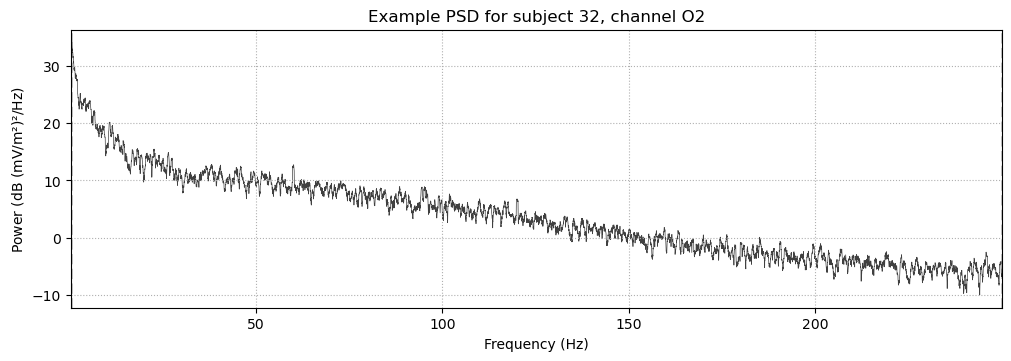

In [4]:
example_subject = '32'
psd_method = 'multitaper'
example_raw =  mne.io.read_raw_fif(data_pathdict[example_subject]['closed'][0], verbose=0)
channels = du.isolate_eeg_channels(example_raw.ch_names)
example_psd = example_raw.compute_psd(fmin=0.3, fmax=250, method=psd_method, picks=channels, verbose=0, bandwidth=0.5)
example_psd.plot(picks='O2')
plt.title('Example PSD for subject 32, channel O2');
plt.show()


## make epochs

In [5]:

example_epochs_og = ec.raw2randomepochs(example_subject, data_pathdict[example_subject], window_len=10, epochs_per_subject=10, which_segment='both', include_ecg=False, states=['closed'], verbose=True)


Creating random epochs for 32 1/1 ...  finished in 0.5543773174285889 seconds


/home/ap60/github/CanonParam/CanonParam/_temporary_data_loading/epoch_creation.py:187: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  assert rand_epochs.get_data().shape[0] == epochs_per_subject, f'Expected {epochs_per_subject} epochs, got {rand_epochs.get_data().shape[0]}'


In [6]:
epochs_scaler = mne.decoding.Scaler(scalings='median')
epochs_pick = example_epochs_og['closed'].copy().pick(channels)
scaled_epochs = epochs_scaler.fit_transform(epochs_pick.get_data(picks=channels))
epochs_info = epochs_pick.info
example_epochs = mne.EpochsArray(scaled_epochs, epochs_info, tmin=example_epochs_og['closed'].tmin, verbose=0)


Plotting power spectral density (dB=True).
Averaging across epochs...
Need more than one channel to make topography for csd. Disabling interactivity.


/tmp/ipykernel_2907008/2235482003.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  example_epochs_psd.plot(picks='O2')
/home/ap60/.conda/envs/canon_param/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


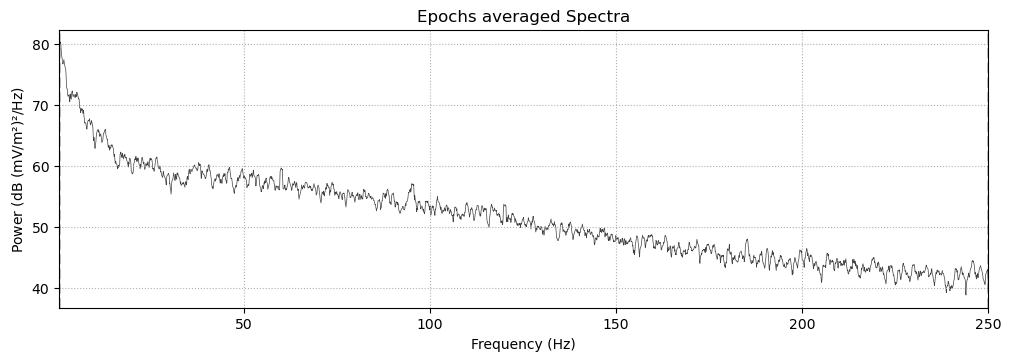

In [7]:
example_epochs_psd = example_epochs.compute_psd(fmin=0.3, fmax=250, method=psd_method, verbose=0, picks=channels)
example_epochs_psd.plot(picks='O2')
plt.title('Epochs averaged Spectra')
plt.show()

In [8]:
example_epochs_og['closed'].copy().pick(channels)

Number of events,10
Events,1: 10
Time range,0.000 – 9.998 s
Baseline,off


(2495,) (19, 2495)


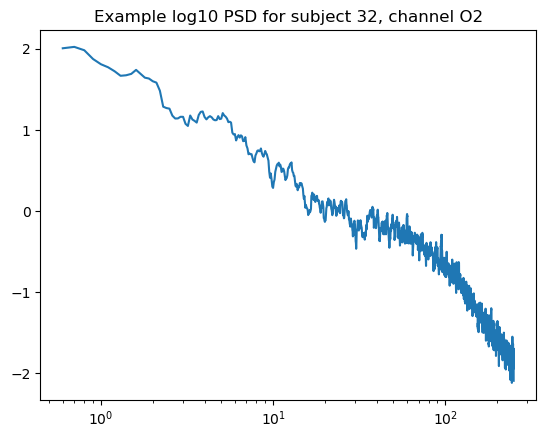

In [9]:
sample_freqs, sample_psd = example_epochs_psd.freqs, np.mean(example_epochs_psd.data, axis=0)
sample_psd = sample_psd[:, sample_freqs > 0.5]
sample_freqs = sample_freqs[sample_freqs > 0.5]
chdx = channels.index('O2')
print(sample_freqs.shape, sample_psd.shape)
plt.plot(sample_freqs, np.log10(sample_psd)[chdx])
plt.title('Example log10 PSD for subject 32, channel O2')
plt.xscale('log')
plt.show()

# theirs vs ours

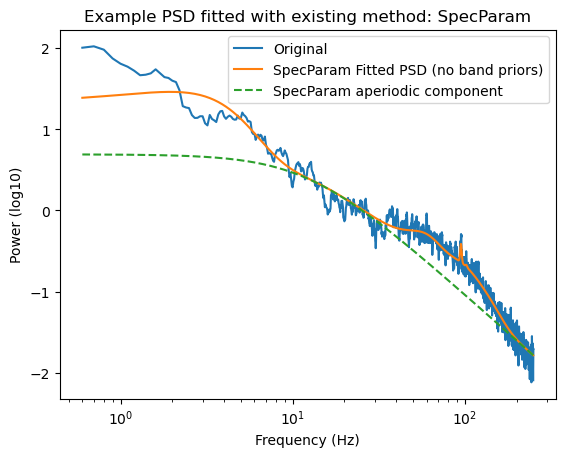

In [10]:
max_n_peaks=7
fm = fooof.FOOOF(peak_width_limits=(2.0, 100.0), max_n_peaks=max_n_peaks, min_peak_height=0.2, peak_threshold=2.0, aperiodic_mode='knee', verbose=True)
# freqs0, power0 = interpolate_notches(notches, notch_width, freqs, open_power[0,0,:])
channel = 'O2'
chdx = channels.index(channel)
fm.fit(freqs=sample_freqs, power_spectrum=sample_psd[chdx,:]) # taking forever when unconstrained. 
plt.plot(sample_freqs, np.log10(sample_psd[chdx,:]), label='Original')
plt.plot(sample_freqs, fm._ap_fit+fm._peak_fit, label='SpecParam Fitted PSD (no band priors)')
plt.plot(sample_freqs, fm._ap_fit, label='SpecParam aperiodic component', linestyle='--')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (log10)')
plt.xscale('log')
plt.title('Example PSD fitted with existing method: SpecParam')
plt.show()

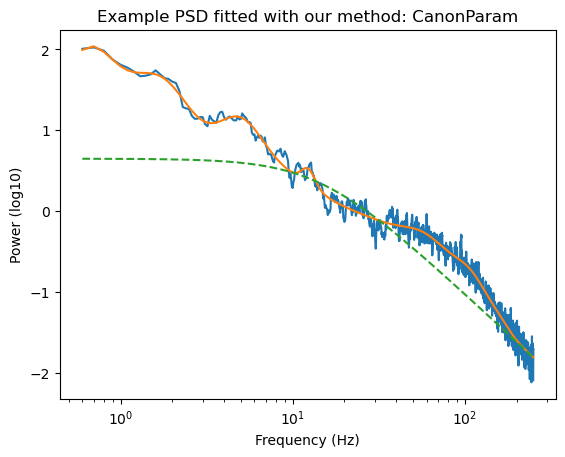

In [11]:
import importlib
importlib.reload(bandparams)
our_fitted_ps = bandparams.extract_param_spectra(sample_freqs, sample_psd[chdx,:])
our_fitted_model = our_fitted_ps.modeled_spectrum_
plt.plot(sample_freqs, np.log10(sample_psd[chdx,:]), label='Original')
plt.plot(sample_freqs, our_fitted_model, label='Our Fitted PSD (with band priors)')
plt.plot(sample_freqs, our_fitted_ps._ap_fit, label='Our Fitted aperiodic component', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (log10)')
plt.xscale('log')
plt.title('Example PSD fitted with our method: CanonParam')
plt.show()  

# save this data for future use

In [12]:
np.savez('../data/example_comparison_spectra.npz', sample_freqs=sample_freqs, sample_psd=sample_psd, channels=channels)